<h1 style="font-size:2rem;color:green;">English to Portuguese Translator LLM</h1>

## Set up PyTorch

In [1]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install pandas
!pip install ipywidgets
!pip install widgetsnbextension
!pip install jupyter_contrib_nbextensions
!jupyter contrib nbextension install --user
!jupyter nbextension enable --py widgetsnbextension --sys-prefix

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://download.pytorch.org/whl/cu118
DEPRECATION: flatbuffers 1.12.1-git20200711.33e2d80-dfsg1-0.6 has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of flatbuffers or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: flatbuffers 1.12.1-git20200711.33e2d80-dfsg1-0.6 has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of flatbuffers or contact the author to suggest that they release a version with a conf

## 1. Import the necessary libraries and modules

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import math
import copy
import pandas as pd

/tmp/ipykernel_276048/547781205.py:7: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## 2. Defining the basic building blocks: Multi-Head Attention, Position-wise Feed-Forward Networks, Positional Encoding

In [3]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        # Ensure that the model dimension (d_model) is divisible by the number of heads
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        
        # Initialize dimensions
        self.d_model = d_model # Model's dimension
        self.num_heads = num_heads # Number of attention heads
        self.d_k = d_model // num_heads # Dimension of each head's key, query, and value
        
        # Linear layers for transforming inputs
        self.W_q = nn.Linear(d_model, d_model) # Query transformation
        self.W_k = nn.Linear(d_model, d_model) # Key transformation
        self.W_v = nn.Linear(d_model, d_model) # Value transformation
        self.W_o = nn.Linear(d_model, d_model) # Output transformation
        
    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        # Calculate attention scores
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        
        # Apply mask if provided (useful for preventing attention to certain parts like padding)
        if mask is not None:
            _MASKING_VALUE = -1e+30 if attn_scores.dtype == torch.float32 else -1e+4            
            attn_scores = attn_scores.masked_fill(mask == 0, value=_MASKING_VALUE)
        
        # Softmax is applied to obtain attention probabilities
        attn_probs = torch.softmax(attn_scores, dim=-1)
        
        # Multiply by values to obtain the final output
        output = torch.matmul(attn_probs, V)
        return output
        
    def split_heads(self, x):
        # Reshape the input to have num_heads for multi-head attention
        batch_size, seq_length, d_model = x.size()
        return x.view(batch_size, seq_length, self.num_heads, self.d_k).transpose(1, 2)
        
    def combine_heads(self, x):
        # Combine the multiple heads back to original shape
        batch_size, _, seq_length, d_k = x.size()
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model)
        
    def forward(self, Q, K, V, mask=None):
        # Apply linear transformations and split heads
        Q = self.split_heads(self.W_q(Q))
        K = self.split_heads(self.W_k(K))
        V = self.split_heads(self.W_v(V))
        
        # Perform scaled dot-product attention
        attn_output = self.scaled_dot_product_attention(Q, K, V, mask)
        
        # Combine heads and apply output transformation
        output = self.W_o(self.combine_heads(attn_output))
        return output

### Position-wise Feed-Forward Networks

In [4]:
class PositionWiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super(PositionWiseFeedForward, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))

### Positional Encoding

In [5]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length):
        super(PositionalEncoding, self).__init__()

        self.max_seq_length = max_seq_length  # Store max_seq_length explicitly
        pe = torch.zeros(max_seq_length, d_model)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        self.register_buffer('pe', pe.unsqueeze(0))
        
    def forward(self, x):
        # print(f'x size: {x.size()}')
        # print(f'self.pe size: {self.pe.size()}')
        return x + self.pe[:, :x.size(1)]

## 3. Building the Encoder Blocks

In [6]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, mask):
        attn_output = self.self_attn(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x

## 4. Building the Decoder Blocks

In [7]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.cross_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, enc_output, src_mask, tgt_mask):
        attn_output = self.self_attn(x, x, x, tgt_mask)
        x = self.norm1(x + self.dropout(attn_output))
        attn_output = self.cross_attn(x, enc_output, enc_output, src_mask)
        x = self.norm2(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm3(x + self.dropout(ff_output))
        return x

## 5. Combine the Encoder and Decoder layers to complete the Transformer network

In [8]:
class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout):
        super(Transformer, self).__init__()
        self.encoder_embedding = nn.Embedding(src_vocab_size, d_model)
        self.decoder_embedding = nn.Embedding(tgt_vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_seq_length)
        
        self.encoder_layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.decoder_layers = nn.ModuleList([DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])

        self.fc = nn.Linear(d_model, tgt_vocab_size)
        self.dropout = nn.Dropout(dropout)

    def generate_mask(self, src, tgt):
        src_mask = (src != 0).unsqueeze(1).unsqueeze(2)
        tgt_mask = (tgt != 0).unsqueeze(1).unsqueeze(3)
        seq_length = tgt.size(1)
        nopeak_mask = (1 - torch.triu(torch.ones(1, seq_length, seq_length), diagonal=1)).bool()
        # Ensure tgt_mask is on the same device as tgt
        #tgt_mask = tgt_mask.to(tgt.device)

        nopeak_mask = nopeak_mask.to(tgt.device)
        
        tgt_mask = tgt_mask & nopeak_mask
        
        return src_mask, tgt_mask

    def forward(self, src, tgt):
        src_mask, tgt_mask = self.generate_mask(src, tgt)
        src_embedded = self.dropout(self.positional_encoding(self.encoder_embedding(src)))
        tgt_embedded = self.dropout(self.positional_encoding(self.decoder_embedding(tgt)))
    
        enc_output = src_embedded
        for enc_layer in self.encoder_layers:
            enc_output = enc_layer(enc_output, src_mask)
    
        dec_output = tgt_embedded
        for dec_layer in self.decoder_layers:
            dec_output = dec_layer(dec_output, enc_output, src_mask, tgt_mask)

        output = self.fc(dec_output)
        return output

<h1 style="font-size:2rem;color:green;">Dataset Loading and Tokenization, and Model Training</h1>

# Import Libraries

In [9]:
!pip install torchtext==0.6.0 spacy numpy nltk scikit-learn tqdm matplotlib

Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: flatbuffers 1.12.1-git20200711.33e2d80-dfsg1-0.6 has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of flatbuffers or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [10]:
import os
import torchtext
from torchtext.data import get_tokenizer, Field, TabularDataset
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.cuda.amp import GradScaler, autocast
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import numpy as np
import re
import nltk
nltk.download('punkt')
import spacy
spacy.cli.download("en_core_web_sm")
spacy.cli.download("pt_core_news_sm")
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /home/ubuntu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 164.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 119.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')


# Load English to Portuguese Translation Dataset

In [11]:
# Load English to Portuguese translation data
dataset_file_path = './por.txt'  # Adjust the path accordingly

# Load and preprocess translation data
df = pd.read_csv(dataset_file_path, sep='\t', header=None)[[0, 1]].rename(columns={0: 'EN', 1: 'PT'})

df.head()

,EN,PT
0,Go.,Vai.
1,Go.,Vá.
2,Hi.,Oi.
3,Run!,Corre!
4,Run!,Corra!


In [12]:
df.shape

(168903, 2)

In [13]:
# Shuffle the rows and reindex
df = df.sample(frac = 1).reset_index(drop=True)

df.head()

,EN,PT
0,It's a miracle that Tom is still alive.,É um milagre que Tom ainda esteja vivo.
1,Even Tom is a little interested in learning Fr...,Até o Tom tem algum interesse em aprender fran...
2,I wonder what Tom is laughing about.,Me pergunto sobre o que o Tom está rindo.
3,Do you like baseball?,Vocês gostam de basebol?
4,Please do this for me.,"Por favor, faz isso por mim."


In [14]:
df = df[:100000]

df.shape

(100000, 2)

In [15]:
# Add Extra Context for Tranformer
df['PT'] = df['PT'].apply(lambda x: "<SOS> " + x + " <EOS>")

df.head()

,EN,PT
0,It's a miracle that Tom is still alive.,<SOS> É um milagre que Tom ainda esteja vivo. ...
1,Even Tom is a little interested in learning Fr...,<SOS> Até o Tom tem algum interesse em aprende...
2,I wonder what Tom is laughing about.,<SOS> Me pergunto sobre o que o Tom está rindo...
3,Do you like baseball?,<SOS> Vocês gostam de basebol? <EOS>
4,Please do this for me.,"<SOS> Por favor, faz isso por mim. <EOS>"


# Preprocess/Tokenize Dataset

In [16]:
def eng_preprocess(text):
    text = text.lower()
    text = re.sub(re.compile(r'[^a-zA-Z0-9\s]'), '', text)
    text = nltk.word_tokenize(text)
    text = " ".join([i.strip() for i in text])
    return text


def pt_preprocess(text):
    text = text.replace("\u202f"," ")
    text = text.lower()
    text = re.sub(re.compile("[^a-zéâàçêêëôîû!?',]"), ' ', text)
    return text

In [17]:
df['EN'] = df['EN'].apply(lambda x: eng_preprocess(x))

df.head()

,EN,PT
0,its a miracle that tom is still alive,<SOS> É um milagre que Tom ainda esteja vivo. ...
1,even tom is a little interested in learning fr...,<SOS> Até o Tom tem algum interesse em aprende...
2,i wonder what tom is laughing about,<SOS> Me pergunto sobre o que o Tom está rindo...
3,do you like baseball,<SOS> Vocês gostam de basebol? <EOS>
4,please do this for me,"<SOS> Por favor, faz isso por mim. <EOS>"


In [18]:
df['PT'] = df['PT'].apply(lambda x: pt_preprocess(x))

df.head()

,EN,PT
0,its a miracle that tom is still alive,sos é um milagre que tom ainda esteja vivo ...
1,even tom is a little interested in learning fr...,sos até o tom tem algum interesse em aprende...
2,i wonder what tom is laughing about,sos me pergunto sobre o que o tom est rindo...
3,do you like baseball,sos vocês gostam de basebol? eos
4,please do this for me,"sos por favor, faz isso por mim eos"


# Tokenize Features and Targets

In [19]:
def feature_tokenization(feat):
    # Step 1: Create a tokenizer
    tokenizer = get_tokenizer("spacy", language="en_core_web_sm")

    # Step 2: Create a torchtext Field for English features
    eng_field = Field(tokenize=tokenizer, lower=True)

    # Step 3: Use the Field to process the feature text
    eng_field.build_vocab([eng_field.preprocess(f) for f in feat])

    # Step 4: Convert feature text to sequences
    eng_seq = [eng_field.numericalize([f]) for f in feat]

    # Step 5: Convert PyTorch tensors to Python lists
    eng_seq = [seq.squeeze().tolist() for seq in eng_seq]

    return eng_seq, eng_field

def target_tokenization(target):
    # Step 1: Create a tokenizer
    tokenizer = get_tokenizer("spacy", language="pt_core_news_sm")

    # Step 2: Create a torchtext Field for Portuguese targets
    port_field = Field(tokenize=tokenizer, init_token='<sos>', eos_token='<eos>', lower=True)

    # Step 3: Use the Field to process the target text
    port_field.build_vocab([port_field.preprocess(t) for t in target])

    # Step 4: Convert target text to sequences
    port_seq = [port_field.numericalize([t]) for t in target]

    # Step 5: Convert PyTorch tensors to Python lists
    port_seq = [seq.squeeze().tolist() for seq in port_seq]

    return port_seq, port_field

In [20]:
eng_sequences, eng_field = feature_tokenization(df['EN'])

In [21]:
eng_vocab = len(eng_field.vocab) + 1
eng_vocab

10710

In [22]:
eng_sequences[:5]

[[2,
  0,
  34,
  0,
  10,
  0,
  25,
  2,
  0,
  10,
  3131,
  0,
  0,
  0,
  0,
  0,
  10,
  0,
  0,
  0,
  0,
  25,
  0,
  2,
  34,
  0,
  34,
  0,
  2,
  0,
  0,
  0,
  10,
  0,
  2,
  0,
  0],
 [0,
  0,
  0,
  0,
  0,
  0,
  0,
  25,
  0,
  2,
  34,
  0,
  10,
  0,
  0,
  2,
  0,
  0,
  0,
  0,
  0,
  2,
  0,
  0,
  0,
  0,
  0,
  34,
  0,
  0,
  83,
  0,
  2,
  0,
  0,
  0,
  0,
  10,
  0,
  0,
  2,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  3131,
  0],
 [2,
  0,
  0,
  0,
  0,
  83,
  0,
  0,
  0,
  0,
  0,
  10,
  0,
  0,
  0,
  0,
  25,
  0,
  2,
  34,
  0,
  0,
  10,
  0,
  0,
  0,
  2,
  0,
  0,
  0,
  10,
  4146,
  0,
  0,
  0],
 [83, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 4146, 10, 34, 0, 4146, 10, 0, 0],
 [9397, 0, 0, 10, 34, 0, 0, 83, 0, 0, 0, 0, 2, 34, 0, 0, 0, 0, 0, 25, 0]]

In [23]:
port_sequences, port_field = target_tokenization(df['PT'])

In [24]:
port_vocab = len(port_field.vocab) + 1
port_vocab

16448

In [25]:
port_sequences[:5]

[[4,
  23,
  8,
  23,
  4,
  4,
  17,
  4,
  6402,
  85,
  4,
  85,
  1033,
  94,
  15,
  2609,
  232,
  35,
  4,
  0,
  6402,
  35,
  4,
  83,
  8,
  85,
  4,
  15,
  1033,
  10,
  194,
  15,
  4,
  35,
  23,
  83,
  35,
  73,
  15,
  4,
  124,
  1033,
  124,
  8,
  4,
  4,
  4,
  35,
  8,
  23,
  4],
 [4,
  23,
  8,
  23,
  4,
  4,
  15,
  83,
  17,
  4,
  8,
  4,
  83,
  8,
  85,
  4,
  83,
  35,
  85,
  4,
  15,
  94,
  2609,
  6402,
  85,
  4,
  1033,
  10,
  83,
  35,
  232,
  35,
  23,
  23,
  35,
  4,
  35,
  85,
  4,
  15,
  256,
  232,
  35,
  10,
  194,
  35,
  232,
  4,
  243,
  232,
  15,
  10,
  418,
  0,
  23,
  4,
  4,
  4,
  35,
  8,
  23,
  4],
 [4,
  23,
  8,
  23,
  4,
  4,
  85,
  35,
  4,
  256,
  35,
  232,
  2609,
  6402,
  10,
  83,
  8,
  4,
  23,
  8,
  1939,
  232,
  35,
  4,
  8,
  4,
  0,
  6402,
  35,
  4,
  8,
  4,
  83,
  8,
  85,
  4,
  35,
  23,
  83,
  4,
  4,
  232,
  1033,
  10,
  194,
  8,
  4,
  4,
  4,
  35,
  8,
  23,
  4],
 [4,
  23,
  8,
  23

In [26]:
port_inp = [x[:-1] for x in port_sequences]
port_inp[:5]

[[4,
  23,
  8,
  23,
  4,
  4,
  17,
  4,
  6402,
  85,
  4,
  85,
  1033,
  94,
  15,
  2609,
  232,
  35,
  4,
  0,
  6402,
  35,
  4,
  83,
  8,
  85,
  4,
  15,
  1033,
  10,
  194,
  15,
  4,
  35,
  23,
  83,
  35,
  73,
  15,
  4,
  124,
  1033,
  124,
  8,
  4,
  4,
  4,
  35,
  8,
  23],
 [4,
  23,
  8,
  23,
  4,
  4,
  15,
  83,
  17,
  4,
  8,
  4,
  83,
  8,
  85,
  4,
  83,
  35,
  85,
  4,
  15,
  94,
  2609,
  6402,
  85,
  4,
  1033,
  10,
  83,
  35,
  232,
  35,
  23,
  23,
  35,
  4,
  35,
  85,
  4,
  15,
  256,
  232,
  35,
  10,
  194,
  35,
  232,
  4,
  243,
  232,
  15,
  10,
  418,
  0,
  23,
  4,
  4,
  4,
  35,
  8,
  23],
 [4,
  23,
  8,
  23,
  4,
  4,
  85,
  35,
  4,
  256,
  35,
  232,
  2609,
  6402,
  10,
  83,
  8,
  4,
  23,
  8,
  1939,
  232,
  35,
  4,
  8,
  4,
  0,
  6402,
  35,
  4,
  8,
  4,
  83,
  8,
  85,
  4,
  35,
  23,
  83,
  4,
  4,
  232,
  1033,
  10,
  194,
  8,
  4,
  4,
  4,
  35,
  8,
  23],
 [4,
  23,
  8,
  23,
  4,
  4,
  1

In [27]:
port_out = [x[1:] for x in port_sequences]
port_out[:5]

[[23,
  8,
  23,
  4,
  4,
  17,
  4,
  6402,
  85,
  4,
  85,
  1033,
  94,
  15,
  2609,
  232,
  35,
  4,
  0,
  6402,
  35,
  4,
  83,
  8,
  85,
  4,
  15,
  1033,
  10,
  194,
  15,
  4,
  35,
  23,
  83,
  35,
  73,
  15,
  4,
  124,
  1033,
  124,
  8,
  4,
  4,
  4,
  35,
  8,
  23,
  4],
 [23,
  8,
  23,
  4,
  4,
  15,
  83,
  17,
  4,
  8,
  4,
  83,
  8,
  85,
  4,
  83,
  35,
  85,
  4,
  15,
  94,
  2609,
  6402,
  85,
  4,
  1033,
  10,
  83,
  35,
  232,
  35,
  23,
  23,
  35,
  4,
  35,
  85,
  4,
  15,
  256,
  232,
  35,
  10,
  194,
  35,
  232,
  4,
  243,
  232,
  15,
  10,
  418,
  0,
  23,
  4,
  4,
  4,
  35,
  8,
  23,
  4],
 [23,
  8,
  23,
  4,
  4,
  85,
  35,
  4,
  256,
  35,
  232,
  2609,
  6402,
  10,
  83,
  8,
  4,
  23,
  8,
  1939,
  232,
  35,
  4,
  8,
  4,
  0,
  6402,
  35,
  4,
  8,
  4,
  83,
  8,
  85,
  4,
  35,
  23,
  83,
  4,
  4,
  232,
  1033,
  10,
  194,
  8,
  4,
  4,
  4,
  35,
  8,
  23,
  4],
 [23,
  8,
  23,
  4,
  4,
  124,
 

# Pad Sequence

In [28]:
def pad_seq(pad):
    # Convert to PyTorch tensor
    pad_tensor = [torch.tensor(seq) for seq in pad]
    
    # Pad sequences using pad_sequence
    padded_seq = pad_sequence(pad_tensor, batch_first=True, padding_value=0)
    
    return padded_seq

In [29]:
encoder_input = pad_seq(eng_sequences)
encoder_input

tensor([[ 2,  0, 34,  ...,  0,  0,  0],
        [ 0,  0,  0,  ...,  0,  0,  0],
        [ 2,  0,  0,  ...,  0,  0,  0],
        ...,
        [ 2,  0,  0,  ...,  0,  0,  0],
        [ 0,  0,  0,  ...,  0,  0,  0],
        [34,  0,  0,  ...,  0,  0,  0]])

In [30]:
encoder_input.shape

torch.Size([100000, 188])

In [31]:
decoder_input = pad_seq(port_inp)
decoder_input

tensor([[ 4, 23,  8,  ...,  0,  0,  0],
        [ 4, 23,  8,  ...,  0,  0,  0],
        [ 4, 23,  8,  ...,  0,  0,  0],
        ...,
        [ 4, 23,  8,  ...,  0,  0,  0],
        [ 4, 23,  8,  ...,  0,  0,  0],
        [ 4, 23,  8,  ...,  0,  0,  0]])

In [32]:
decoder_input.shape

torch.Size([100000, 194])

In [33]:
decoder_output = pad_seq(port_out)
decoder_output

tensor([[23,  8, 23,  ...,  0,  0,  0],
        [23,  8, 23,  ...,  0,  0,  0],
        [23,  8, 23,  ...,  0,  0,  0],
        ...,
        [23,  8, 23,  ...,  0,  0,  0],
        [23,  8, 23,  ...,  0,  0,  0],
        [23,  8, 23,  ...,  0,  0,  0]])

In [34]:
decoder_output.shape

torch.Size([100000, 194])

# Training the PyTorch Transformer Model

In [35]:
# Hyperparameters
src_vocab_size = eng_vocab
tgt_vocab_size = port_vocab
batch_size = 128
d_model = 512
num_heads = 8
num_layers = 6
d_ff = 1024 #prev 2048
max_seq_len = max(encoder_input.size(1), decoder_input.size(1))
dropout = 0.1
epoch = None

# Use GPU if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Current device: {device}")

# Sequence Length
src_seq_len = encoder_input.shape[1]
tgt_seq_len = decoder_input.shape[1]

# Src and tgt datasets
src_data = encoder_input
tgt_data = decoder_input

# Create an instance of the Transformer model
transformer = Transformer(src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_len, dropout)

# Move model and data to the selected device
transformer.to(device)

# Print the device on which the model parameters are located
print(f"Model parameters device: {next(transformer.parameters()).device}")

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

# Create ReduceLROnPlateau scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.1)

# Scaler
scaler = GradScaler()

Current device: cuda
Model parameters device: cuda:0


## Prepare Training and Validation Splits, and DataLoaders

In [36]:
# Split the data into training and validation sets
train_src_data, val_src_data, train_tgt_data, val_tgt_data = train_test_split(
    src_data, tgt_data, test_size=0.2, random_state=42
)

In [37]:
# Assuming you have a custom dataset class, let's call it MyDataset
class MyDataset(Dataset):
    def __init__(self, src_data, tgt_data):
        self.src_data = src_data
        self.tgt_data = tgt_data

    def __len__(self):
        return len(self.src_data)

    def __getitem__(self, idx):
        src_sample = self.src_data[idx].to(device)
        tgt_sample = self.tgt_data[idx].to(device)
        return src_sample, tgt_sample

In [38]:
# Create an instance of your dataset
train_dataset = MyDataset(train_src_data, train_tgt_data)

# Create a DataLoader for training
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [39]:
# Create an instance of your validation dataset
val_dataset = MyDataset(val_src_data, val_tgt_data)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

## Compute Accuracy Function

In [40]:
def compute_accuracy(output, target):
    """
    Compute accuracy based on the model's output and target values.

    Args:
    - output (torch.Tensor): Model's output tensor.
    - target (torch.Tensor): Target tensor.

    Returns:
    - accuracy (float): Accuracy value.
    """
    # Assuming output and target are tensors
    # Get the predicted indices with maximum probability
    _, predicted = torch.max(output, dim=2)

    # Mask for valid positions (non-padding)
    mask = (target != 0).float()

    # Compare predicted and target values, count correct predictions
    correct = (predicted == target) * mask

    # Calculate accuracy
    accuracy = correct.sum().item() / mask.sum().item() if mask.sum().item() > 0 else 0.0

    return accuracy

## Create/Load Checkpoints and Training Progress

In [41]:
# File path for the saved checkpoint
checkpoint_file_path = './checkpoint.pth'

# Check if the file exists
if os.path.exists(checkpoint_file_path):
    # Load the saved checkpoint
    checkpoint = torch.load(checkpoint_file_path)

    # Load epoch
    epoch = checkpoint['epoch']

    # Load transformer
    transformer_checkpoint = checkpoint['model_state_dict']
    keys_to_load = ['encoder_embedding', 'decoder_embedding', 'positional_encoding', 
                    'encoder_layers', 'decoder_layers', 'fc']
    filtered_state_dict = {k: v for k, v in transformer_checkpoint.items() if k in keys_to_load}
    transformer.load_state_dict(filtered_state_dict, strict=False)
    #transformer.load_state_dict(checkpoint['model_state_dict'])

    # Load the optimizer state dict
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    # Load Scheduler
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

    # Load Scaler
    scaler.load_state_dict(checkpoint['scaler_state_dict'])
    
    print("Checkpoint loaded successfully")

else:
    # If the file doesn't exist, create and save checkpoint
    epoch = 0
    torch.save({
    'epoch': epoch,
    'model_state_dict': transformer.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    'scaler_state_dict': scaler.state_dict(),
    }, checkpoint_file_path)
    print("Checkpoint file not found. Initial checkpoint created and saved.")

Checkpoint loaded successfully


In [42]:
# File path for the saved checkpoint
progress_file_path = './training_progress.pth'
training_progress = None

# Check if the file exists
if os.path.exists(progress_file_path):
    # Load the saved checkpoint
    print("Training progress loaded successfully")
    training_progress = torch.load(progress_file_path)

    print("Information in the training progress:")
    for epoch_info in training_progress:
        print(f"Epoch: {epoch_info['epoch']}, "
              f"Avg Loss: {epoch_info['avg_loss']:.4f}, "
              f"Avg Accuracy: {epoch_info['avg_accuracy']:.4f}, "
              f"Avg Val Loss: {epoch_info['avg_val_loss']:.4f}, "
              f"Avg Val Accuracy: {epoch_info['avg_val_accuracy']:.4f}, "
              f"Learning Rate: {epoch_info['learning_rate']:.4f}")


else:
    # If the file doesn't exist, create and save training progress
    training_progress = []
    torch.save(training_progress, progress_file_path)
    print("Training progress file not found. File created and saved.")

Training progress loaded successfully
Information in the training progress:
Epoch: 1, Avg Loss: 1.8855, Avg Accuracy: 0.5003, Avg Val Loss: 1.2903, Avg Val Accuracy: 0.6045, Learning Rate: 0.0001
Epoch: 2, Avg Loss: 1.1473, Avg Accuracy: 0.6478, Avg Val Loss: 1.0379, Avg Val Accuracy: 0.6813, Learning Rate: 0.0001
Epoch: 3, Avg Loss: 0.9614, Avg Accuracy: 0.7041, Avg Val Loss: 0.8999, Avg Val Accuracy: 0.7224, Learning Rate: 0.0001
Epoch: 4, Avg Loss: 0.8528, Avg Accuracy: 0.7373, Avg Val Loss: 0.8231, Avg Val Accuracy: 0.7463, Learning Rate: 0.0001
Epoch: 5, Avg Loss: 0.7869, Avg Accuracy: 0.7568, Avg Val Loss: 0.7749, Avg Val Accuracy: 0.7610, Learning Rate: 0.0001
Epoch: 6, Avg Loss: 0.7359, Avg Accuracy: 0.7727, Avg Val Loss: 0.7340, Avg Val Accuracy: 0.7734, Learning Rate: 0.0001
Epoch: 7, Avg Loss: 0.6910, Avg Accuracy: 0.7864, Avg Val Loss: 0.7007, Avg Val Accuracy: 0.7840, Learning Rate: 0.0001
Epoch: 8, Avg Loss: 0.6570, Avg Accuracy: 0.7965, Avg Val Loss: 0.6755, Avg Val Accu

In [43]:
# Set the model to evaluation mode
transformer.eval()

Transformer(
  (encoder_embedding): Embedding(10710, 512)
  (decoder_embedding): Embedding(16448, 512)
  (positional_encoding): PositionalEncoding()
  (encoder_layers): ModuleList(
    (0-5): 6 x EncoderLayer(
      (self_attn): MultiHeadAttention(
        (W_q): Linear(in_features=512, out_features=512, bias=True)
        (W_k): Linear(in_features=512, out_features=512, bias=True)
        (W_v): Linear(in_features=512, out_features=512, bias=True)
        (W_o): Linear(in_features=512, out_features=512, bias=True)
      )
      (feed_forward): PositionWiseFeedForward(
        (fc1): Linear(in_features=512, out_features=1024, bias=True)
        (fc2): Linear(in_features=1024, out_features=512, bias=True)
        (relu): ReLU()
      )
      (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (decoder_layers): ModuleList(
    (0-5): 6 x DecoderLayer(

In [44]:
#torch.autograd.set_detect_anomaly(True)

# Training the Model

In [45]:
# Training loop
transformer.train()

for current_epoch in range(epoch, 100):
    epoch = current_epoch
    total_loss = 0.0
    total_accuracy = 0.0
    total_val_loss = 0.0
    total_val_accuracy = 0.0
    
    print(f"Starting Epoch: {epoch+1}")
    optimizer.zero_grad()

    # Run 
    for train_batch_idx, (train_src_batch, train_tgt_batch) in enumerate(tqdm(train_dataloader, desc=f"Epoch {epoch+1}/100, Training Set", position=0, ncols=240), start=1):
        with autocast():
            # Forward Pass
            output = transformer(train_src_batch, train_tgt_batch[:, :-1])

            # Compute the loss using normalized outputs
            loss = criterion(output.contiguous().view(-1, tgt_vocab_size), train_tgt_batch[:, 1:].contiguous().view(-1))

        # Backward Pass
        scaler.scale(loss).backward()

        # Gradient Clipping
#        torch.nn.utils.clip_grad_norm_(transformer.parameters(), max_norm=1)

        # Gradient Norm Clipping
        torch.nn.utils.clip_grad_norm_(transformer.parameters(), max_norm=2.0, norm_type=2)

        # Update Optimizer
        scaler.step(optimizer)
        scaler.update()

        # Accumulate total validation loss
        total_loss += loss.item()
        avg_loss = total_loss / len(train_dataloader)
        
        # Compute accuracy
        train_accuracy = compute_accuracy(output, train_tgt_batch[:, 1:])
        total_accuracy += train_accuracy
        avg_accuracy = total_accuracy / len(train_dataloader)
        
        # Print progress
        if train_batch_idx % 25 == 0:  # Print every 25 batches
            print(f"Epoch: {epoch+1}/100, Train Batch: {train_batch_idx}/{len(train_dataloader)}, Loss: {loss.item():.4f}, Accuracy: {train_accuracy:.4f}")

    print(f"Train_Batch for Epoch {epoch+1} completed. Avg_Loss: {avg_loss:.4f}, Avg_Accuracy: {avg_accuracy:.4f}")

    
    for val_batch_idx, (val_src_batch, val_tgt_batch) in enumerate(tqdm(val_dataloader, desc=f"Epoch {epoch+1}/100, Validation Set", position=0, ncols=240), start=1):
        with torch.no_grad():
            val_output = transformer(val_src_batch, val_tgt_batch[:, :-1])
            val_loss = criterion(val_output.contiguous().view(-1, tgt_vocab_size), val_tgt_batch[:, 1:].contiguous().view(-1))

        # Calculate average validation loss
        total_val_loss += val_loss.item()
        avg_val_loss = total_val_loss / len(val_dataloader)
        
        # Compute accuracy
        val_accuracy = compute_accuracy(val_output, val_tgt_batch[:, 1:])
        total_val_accuracy += val_accuracy
        avg_val_accuracy = total_val_accuracy / len(val_dataloader)
        
        # Print progress
        if val_batch_idx % 25 == 0:  # Print every 25 batches (adjust as needed)
            print(f"Epoch: {epoch+1}/100, Val_Batch: {val_batch_idx}/{len(val_dataloader)}, Val_Loss: {val_loss.item():.4f}, Val_Accuracy: {val_accuracy:.4f}")

    print(f"Val_Batch for Epoch {epoch+1} completed. Avg_Val_Loss: {avg_val_loss:.4f}, Avg_Val_Accuracy: {avg_val_accuracy:.4f}")
    
    # Update scheduler based on validation loss
    scheduler.step(avg_val_loss)
    
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': transformer.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'scaler_state_dict': scaler.state_dict(),
    }, checkpoint_file_path)
    print(f"Model, Optimizer, Scheduler, and Scaler states for Epoch {epoch+1} updated and saved.")
    
    print(f"Epoch {epoch+1} Complete, Avg_Loss: {avg_loss:.4f}, Avg_Accuracy: {avg_accuracy:.4f}, Avg_Val_Loss: {avg_val_loss:.4f}, Avg_Val_Accuracy: {avg_val_accuracy:.4f}")

    current_learning_rate = optimizer.param_groups[0]['lr']
    
    # Save training progress (average loss and average accuracy)
    training_progress.append({
        'epoch': epoch + 1,
        'avg_loss': avg_loss,
        'avg_accuracy': avg_accuracy,
        'avg_val_loss': avg_val_loss,
        'avg_val_accuracy': avg_val_accuracy,
        'learning_rate': current_learning_rate
    })

    print(f"Learning Rate: {current_learning_rate:.8f}")

    # Save the updated training progress
    torch.save(training_progress, progress_file_path)
    print(f"Training progress updated and saved.")

    # Check for early stopping using scheduler metrics
    if scheduler.num_bad_epochs > scheduler.patience:
        print("Early stopping triggered.")
        break

Starting Epoch: 64


Epoch 64/100, Training Set:   0%|                                                                             …

RuntimeError: The size of tensor a (10892) must match the size of tensor b (10710) at non-singleton dimension 0

# Plot a Graph with the info of training progress

In [46]:
def plot_training_progress(training_progress):
    epochs = [entry['epoch'] for entry in training_progress]
    avg_loss = [entry['avg_loss'] for entry in training_progress]
    avg_accuracy = [entry['avg_accuracy'] for entry in training_progress]
    avg_val_loss = [entry['avg_val_loss'] for entry in training_progress]
    avg_val_accuracy = [entry['avg_val_accuracy'] for entry in training_progress]
    learning_rate = [entry['learning_rate'] for entry in training_progress]

    # Plotting Loss
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 1, 1)
    plt.plot(epochs, avg_loss, label='Training Loss')
    plt.plot(epochs, avg_val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plotting Accuracy
    plt.subplot(2, 1, 2)
    plt.plot(epochs, avg_accuracy, label='Training Accuracy')
    plt.plot(epochs, avg_val_accuracy, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Show the plot
    plt.tight_layout()
    plt.show()

    # Plotting Learning Rate
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, learning_rate, label='Learning Rate')
    plt.title('Learning Rate Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Learning Rate')
    plt.legend()
    plt.show()


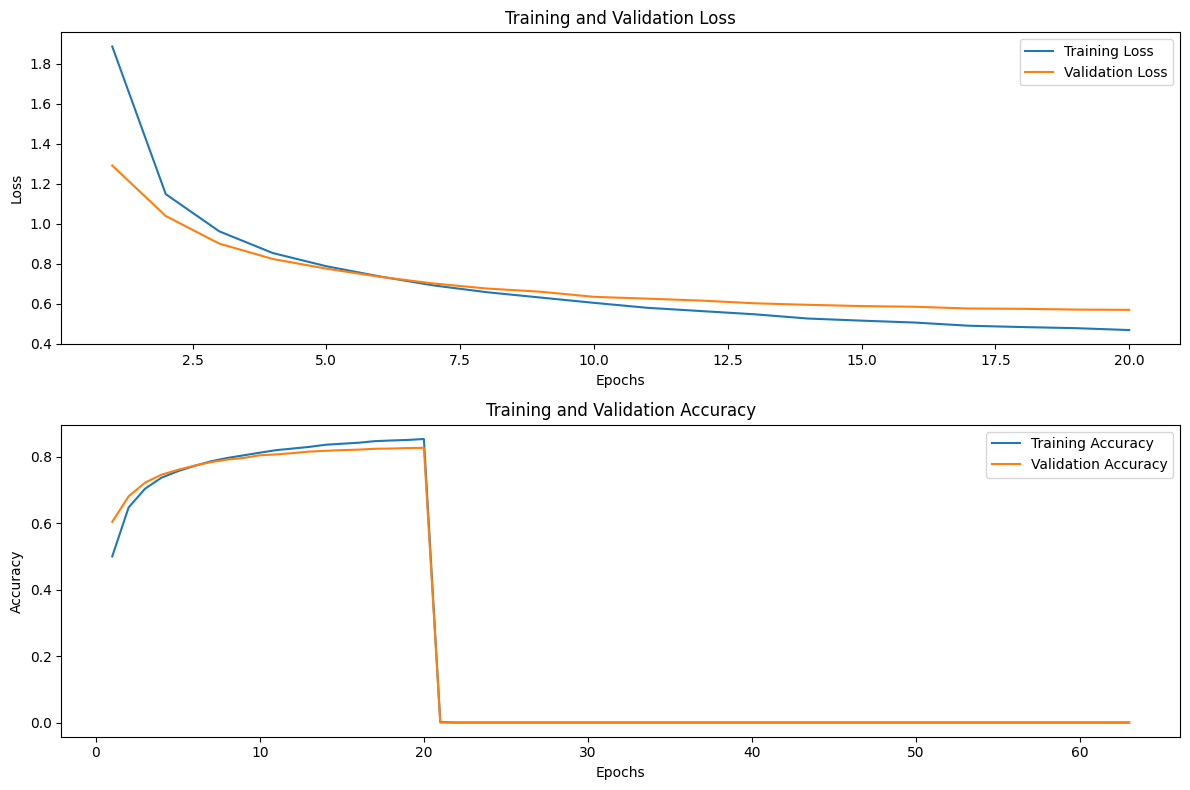

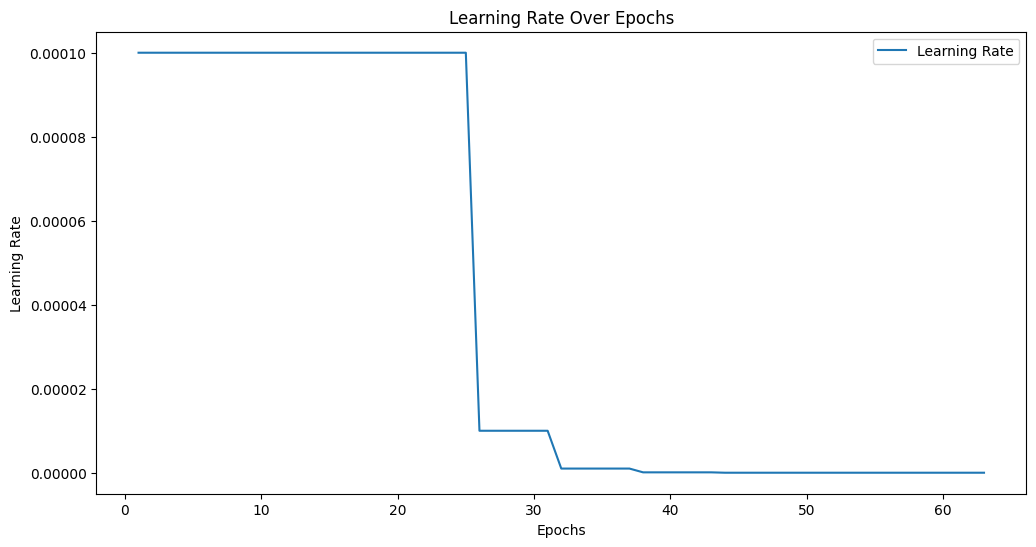

In [47]:
# Call the function to plot the training progress
plot_training_progress(training_progress)

# Prepare Inputs, Decode, and Translate

In [48]:
def prepare_inputs(sentences):
    input_tokenized = eng_field.numericalize([sentences])
    input_padded = pad_sequence(input_tokenized, batch_first=True, padding_value=0)
    
    # Truncate or zero-pad to the specified maxlen
    if input_padded.size(1) > src_seq_len:
        input_padded = input_padded[:, :src_seq_len]
    else:
        input_padded = F.pad(input_padded, (0, src_seq_len - input_padded.size(1)))
    
    input_tensor = torch.tensor(input_padded, dtype=torch.long)
    
    return input_tensor

In [49]:
def decode_process(d):
    target_tokenized = port_field.numericalize([d])
    target_padded = pad_sequence(target_tokenized, batch_first=True, padding_value=0)
    
    # Truncate or zero-pad to the specified maxlen
    if target_padded.size(1) > tgt_seq_len:
        target_padded = target_padded[:, :tgt_seq_len]
    else:
        target_padded = F.pad(target_padded, (0, tgt_seq_len - target_padded.size(1)))
    
    dt = torch.tensor(target_padded, dtype=torch.long)
    
    return dt

In [50]:
decoder_end = ["<EOS>"]
end = port_field.numericalize([decoder_end])
end = end[0].clone().detach()
end

tensor([0])

In [51]:
def translate(inputs):
    # Set the model to evaluation mode
    transformer.eval()
    
    # Prepare input tensor
    tt = prepare_inputs(inputs)
    
    # Initialize the target input with "<SOS>"
    d = ["<sos>"]

    # Numericalize the target input
    dt = decode_process(d)

    # Move tensors to the appropriate device (GPU if available)
    # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    tt = tt.to(device)
    dt = dt.to(device)
    
    # Generate translations
    with torch.no_grad():
        for i in tqdm(range(tgt_seq_len), desc="Generating Translations", position=0, ncols=240):
            # Forward pass
            output = transformer(tt, dt)

            # Get the indices of the predicted tokens at the last position
            pred_indices = torch.argmax(output[:, -1, :], dim=-1)

            # Extract the predicted tokens as a list
            pred_tokens = [port_field.vocab.itos[index.item()] for index in pred_indices]

            # Append the predicted tokens to the target sequence
            d.extend(pred_tokens)

            # Stop if <EOS> is predicted
            if (pred_indices == port_field.vocab.stoi[end]).any():
                break
            
            # Update the target input tensor for the next step
            dt = torch.cat([dt, pred_indices.unsqueeze(0)], dim=-1)
            
            # Enforce max_seq_length by keeping the last max_seq_length elements
            dt = dt[:, -max_seq_len:]

    # Convert the generated translation back to a string
    translation = " ".join(d)

    return translation

In [52]:
for i in range(5):
    print("English Sentence : ", df['EN'][i])
    print("Original Portugal Sentence : ", df['PT'][i])
    print("Predicted Sentence : ", translate(df["EN"][i]))
    print("*" * 50)

English Sentence :  its a miracle that tom is still alive
Original Portugal Sentence :   sos  é um milagre que tom ainda esteja vivo   eos 


/tmp/ipykernel_276048/1569868288.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_tensor = torch.tensor(input_padded, dtype=torch.long)


Generating Translations:   0%|                                                                                …

Predicted Sentence :  <sos> razoavelmene cordas aprenderia cordas cordas cordas mostramos razoavelmene cordas cordas cordas cordas cordas cordas cordas cordas cordas cordas cordas cordas cordas mostramos cordas razoavelmene aprenderia cordas aprenderia cordas razoavelmene cordas cordas cordas cordas cordas razoavelmene cordas cordas velhas acordarem terrestre acordarem cortasse acordarem mapas velhas acordarem cortasse bacanas acordarem acordarem acordarem acordarem acordarem cortasse acordarem acordarem acordarem acordarem mapas acordarem velhas terrestre acordarem terrestre acordarem velhas acordarem acordarem acordarem cortasse acordarem velhas acordarem acordarem fé motoristas vê motoristas rodovias motoristas rap fé motoristas rodovias barba motoristas motoristas motoristas motoristas motoristas rodovias motoristas motoristas motoristas motoristas rap motoristas fé vê motoristas vê motoristas fé motoristas motoristas motoristas rodovias motoristas fé motoristas motoristas retirado

Generating Translations:   0%|                                                                                …

Predicted Sentence :  <sos> cordas cordas cordas cordas cordas cordas cordas mostramos cordas razoavelmene aprenderia cordas cordas cordas cordas razoavelmene cordas cordas cordas cordas cordas razoavelmene cordas cordas cordas cordas cordas aprenderia cordas cordas dirigisse cordas razoavelmene cordas cordas cordas cordas cordas cordas cordas razoavelmene cordas cordas cordas cordas cordas cordas cordas cordas cordas acordarem acordarem acordarem acordarem acordarem acordarem acordarem mapas acordarem deprimente cantavam acordarem cortasse acordarem acordarem deprimente acordarem acordarem acordarem acordarem acordarem deprimente acordarem acordarem acordarem acordarem acordarem cantavam acordarem acordarem engan acordarem deprimente acordarem acordarem acordarem acordarem cortasse acordarem acordarem deprimente acordarem acordarem acordarem acordarem acordarem acordarem acordarem bacanas acordarem motoristas motoristas motoristas motoristas motoristas motoristas motoristas batalha mo

Generating Translations:   0%|                                                                                …

Predicted Sentence :  <sos> razoavelmene cordas cordas cordas cordas dirigisse cordas cordas cordas cordas cordas cordas cordas cordas cordas cordas mostramos cordas razoavelmene aprenderia cordas cordas cordas cordas cordas cordas razoavelmene cordas cordas cordas cordas tenhais cordas cordas cordas velhas acordarem acordarem acordarem acordarem engan acordarem acordarem acordarem acordarem acordarem cortasse acordarem acordarem acordarem acordarem mapas acordarem velhas velhas acordarem acordarem cortasse acordarem acordarem acordarem velhas acordarem acordarem acordarem cortasse dominador acordarem acordarem acordarem fé motoristas motoristas motoristas motoristas repente motoristas motoristas motoristas motoristas motoristas rodovias motoristas motoristas motoristas motoristas rap motoristas fé vê motoristas motoristas rodovias motoristas motoristas motoristas fé motoristas motoristas motoristas rodovias arrumou motoristas motoristas motoristas retirados acordarem acordarem acordar

Generating Translations:   0%|                                                                                …

Predicted Sentence :  <sos> dirigisse cordas cordas cordas cordas cordas cordas cordas razoavelmene cordas cordas cordas tenhais cordas aprenderia cordas tenhais cordas cordas cordas péssima acordarem acordarem acordarem acordarem acordarem acordarem acordarem velhas acordarem acordarem acordarem dominador cortasse velhas acordarem dominador cortasse acordarem acordarem repente motoristas motoristas motoristas motoristas motoristas motoristas motoristas fé motoristas motoristas motoristas arrumou rodovias vê motoristas arrumou rodovias motoristas motoristas primeiro pedacinhos pedacinhos pedacinhos pedacinhos pedacinhos pedacinhos pedacinhos miseravelmente pedacinhos pedacinhos pedacinhos arrumou tolamente indefeso pedacinhos arrumou tolamente pedacinhos pedacinhos praticava pedacinhos pedacinhos pedacinhos pedacinhos pedacinhos pedacinhos pedacinhos yuri pedacinhos pedacinhos pedacinhos arrumou cingapura cocô pedacinhos arrumou cingapura pedacinhos pedacinhos passatempo pedacinhos ped

Generating Translations:   0%|                                                                                …

Predicted Sentence :  <sos> cordas cordas cordas cordas aprenderia cordas cordas dirigisse cordas cordas cordas cordas razoavelmene aprenderia cordas cordas cordas cordas cordas mostramos cordas pensei acordarem acordarem cortasse terrestre acordarem acordarem péssima acordarem acordarem acordarem acordarem velhas terrestre acordarem acordarem acordarem acordarem acordarem mapas acordarem barba motoristas motoristas rodovias vê motoristas motoristas repente motoristas motoristas motoristas motoristas fé vê motoristas motoristas motoristas motoristas motoristas rap motoristas primeiro pedacinhos pedacinhos tolamente indefeso pedacinhos pedacinhos primeiro pedacinhos pedacinhos pedacinhos pedacinhos miseravelmente indefeso pedacinhos pedacinhos pedacinhos pedacinhos pedacinhos primeiro pedacinhos praticava pedacinhos pedacinhos cingapura cocô pedacinhos pedacinhos praticava pedacinhos pedacinhos pedacinhos pedacinhos yuri cocô pedacinhos pedacinhos pedacinhos pedacinhos pedacinhos cingap

In [ ]:
#-------------------------------------------------------------------

# Test Sample Texts

In [53]:
translate("The weather is beautiful today.")

/tmp/ipykernel_276048/1569868288.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_tensor = torch.tensor(input_padded, dtype=torch.long)


Generating Translations:   0%|                                                                                …

'<sos> cordas cordas cordas cordas cordas cordas cordas cordas cordas cordas cordas cordas razoavelmene aprenderia cordas tenhais cordas cordas cordas cordas razoavelmene cordas cordas cordas cordas cordas cordas dirigisse cordas cordas cordas acordarem acordarem acordarem acordarem acordarem acordarem cortasse acordarem acordarem acordarem acordarem acordarem velhas velhas acordarem dominador acordarem cortasse acordarem acordarem velhas acordarem acordarem acordarem acordarem acordarem acordarem engan cortasse acordarem acordarem motoristas motoristas motoristas motoristas motoristas motoristas rodovias motoristas motoristas motoristas motoristas motoristas fé vê motoristas arrumou motoristas rodovias motoristas motoristas fé motoristas motoristas motoristas motoristas motoristas motoristas repente rodovias motoristas motoristas pedacinhos pedacinhos pedacinhos pedacinhos pedacinhos pedacinhos tolamente pedacinhos pedacinhos pedacinhos pedacinhos pedacinhos retirados indefeso pedacin

In [ ]:
translate("I enjoy reading books in my free time.")

In [ ]:
translate("Here is the nearest coffee shop?")

In [ ]:
translate("Learning new languages broadens your perspective.")

In [ ]:
translate("Can you recommend a good restaurant in the area?")

# Input Text and Get Translations

In [54]:
def translate_input():
    while True:
        # Get user input
        user_input = input("Enter an English sentence (type 'exit' to quit): ")

        # Check if the user wants to exit
        if user_input.lower() == 'exit':
            print("Exiting translation program.")
            break

        # Use your existing translate function
        translation = translate(user_input)

        # Display the translation
        print(f"Translation: {translation}\n")

# Call The Translation Function

In [ ]:
translate_input()

Enter an English sentence (type 'exit' to quit):  Hi


/tmp/ipykernel_276048/1569868288.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_tensor = torch.tensor(input_padded, dtype=torch.long)


Generating Translations:   0%|                                                                                …

Translation: <sos> cordas razoavelmene mary fisiculturista pedacinhos fé empalideceu apressem insistir empurrem vença fé empalideceu apressem insistir empurrem vença fé empalideceu esperada pedacinhos razoavelmene mary fisiculturista pedacinhos fé empalideceu esperada pedacinhos razoavelmene mary fisiculturista pedacinhos fé empalideceu esperada pedacinhos razoavelmene mary fisiculturista pedacinhos fé empalideceu esperada pedacinhos razoavelmene mary fisiculturista pedacinhos fé vença esperada pedacinhos razoavelmene mary fisiculturista pedacinhos fé vença esperada pedacinhos psicologia matem lidar mapas mostramos empalideceu lidar mapas mostramos empalideceu lidar mapas mostramos empalideceu lidar mapas mostramos empalideceu lidar mapas mostramos empalideceu lidar mapas mostramos empalideceu lidar mapas mostramos empalideceu lidar mapas mostramos empalideceu lidar mapas mostramos empalideceu lidar mapas mostramos empalideceu cula planejando fisiculturista pedacinhos yuri empalideceu 

Enter an English sentence (type 'exit' to quit):  Nice


Generating Translations:   0%|                                                                                …

Translation: <sos> cordas razoavelmene cordas cordas acordarem velhas bacanas acordarem motoristas fé vê motoristas pedacinhos miseravelmente cordas pedacinhos pedacinhos razoavelmene cordas pedacinhos pedacinhos razoavelmene cordas pedacinhos pedacinhos razoavelmene cordas pedacinhos pedacinhos razoavelmene cordas pedacinhos pedacinhos yuri cordas pedacinhos pedacinhos yuri cordas pedacinhos pedacinhos yuri cordas pedacinhos pedacinhos yuri cordas pedacinhos pedacinhos yuri cordas pedacinhos pedacinhos yuri cordas pedacinhos pedacinhos yuri cordas pedacinhos pedacinhos yuri cordas pedacinhos pedacinhos yuri cordas pedacinhos pedacinhos yuri cordas pedacinhos pedacinhos yuri cordas pedacinhos pedacinhos yuri cordas pedacinhos pedacinhos yuri cordas pedacinhos pedacinhos yuri cordas pedacinhos pedacinhos yuri cordas pedacinhos pedacinhos yuri cordas pedacinhos pedacinhos yuri cordas pedacinhos pedacinhos yuri cordas pedacinhos pedacinhos yuri cordas pedacinhos pedacinhos yuri cordas ped

Enter an English sentence (type 'exit' to quit):  cordas


Generating Translations:   0%|                                                                                …

Translation: <sos> cordas cordas cordas dirigisse cordas aprenderia cordas mary mary dirigiram aprovaram aprovaram cordas cordas cordas venci cordas presas mostramos ssil ssil tratou ssil cantavam comunicar pedacinhos pedacinhos péssima nessa ssil acharem acordarem acordarem gastar superficial vosso tinge vença vença volte corrente ju cordas mary mary marimbondo morreria cantavam comunicar pedacinhos pedacinhos repente nessa ssil acharem acordarem acordarem repente superficial cocô cordas empalideceu empalideceu recomendaria sexy isqueiro fluorescentes mary mary percebe acompanhados terrestre achille vença vença séria nessa terrestre achille vença vença séria nessa terrestre achille vença vença séria nessa terrestre achille vença vença séria nessa terrestre achille vença vença séria nessa terrestre achille vença vença séria nessa terrestre achille vença vença séria nessa terrestre achille vença vença séria nessa terrestre achille vença vença séria nessa terrestre batalha vença vença sé